In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [51]:
import shutil
import argparse

def get_files_from_folder(path):

    files = os.listdir(path)
    return np.asarray(files)

def main(path_to_data, path_to_test_data, train_ratio):
    # get dirs
    _, dirs, _ = next(os.walk(path_to_data))

    # calculates how many train data per class
    data_counter_per_class = np.zeros((len(dirs)))
    for i in range(len(dirs)):
        path = os.path.join(path_to_data, dirs[i])
        files = get_files_from_folder(path)
        data_counter_per_class[i] = len(files)
    test_counter = np.round(data_counter_per_class * (1 - train_ratio))

    # transfers files
    for i in range(len(dirs)):
        path_to_original = os.path.join(path_to_data, dirs[i])
        path_to_save = os.path.join(path_to_test_data, dirs[i])

        #creates dir
        if not os.path.exists(path_to_save):
            os.makedirs(path_to_save)
        files = get_files_from_folder(path_to_original)
        # moves data
        for j in range(int(test_counter[i])):
            dst = os.path.join(path_to_save, files[j])
            src = os.path.join(path_to_original, files[j])
            shutil.move(src, dst)

main('fruit-recognition/train', 'fruit-recognition/test', 0.8)

In [52]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([224,224]),
    transforms.CenterCrop([224,224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [53]:
test_transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.CenterCrop([224,224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [54]:
root = 'fruit-recognition'

train_data = datasets.ImageFolder(os.path.join(root,'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root,'test'), transform=test_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

class_names = train_data.classes

In [55]:
class_names

['Apple',
 'Banana',
 'Carambola',
 'Guava',
 'Kiwi',
 'Mango',
 'Muskmelon',
 'Orange',
 'Peach',
 'Pear',
 'Persimmon',
 'Pitaya',
 'Plum',
 'Pomegranate',
 'Tomatoes']

In [56]:
len(train_data)

35525

In [57]:
len(test_data)

8881

In [58]:
for images,labels in train_loader:
    break

In [59]:
images.shape

torch.Size([10, 3, 224, 224])

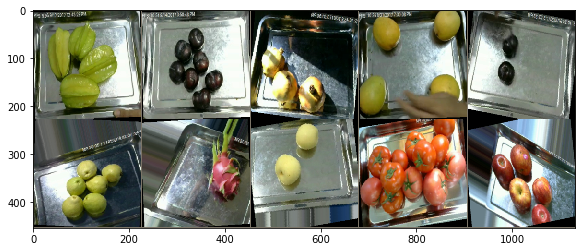

In [60]:
im = make_grid(images,nrow=5)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225])

im_inv = inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))

In [19]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        # (((150-2)/2)-2)/2
        self.fc1 = nn.Linear(36*36*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,15)
        
    def forward(self,X):
        
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,36*36*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X,dim=1)

In [20]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(),lr=0.001)

In [21]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=20736, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=15, bias=True)
)

In [23]:
for p in CNNmodel.parameters():
    print(p.numel())

162
6
864
16
2488320
120
10080
84
1260
15


In [26]:
import time
start_time = time.time()

epochs = 10

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train,y_train) in enumerate(train_loader):
        
        b += 1
        
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred,y_train)
        
        # TaLLy the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            print(f'Epoch: {i} Loss: {loss.item()}')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    # TEST SET!
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
                
            y_val = CNNmodel(X_test)
            
            predicted = torch.max(y_val.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr += batch_corr
            
    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

total_time = time.time() - start_time
print(f'Total Time: {total_time/60} minutes')

Epoch: 0 Loss: 0.648774266242981
Epoch: 0 Loss: 0.3514189124107361
Epoch: 0 Loss: 0.2485712468624115
Epoch: 0 Loss: 0.6212037801742554
Epoch: 0 Loss: 0.14353574812412262
Epoch: 0 Loss: 1.3760930299758911
Epoch: 0 Loss: 0.3211899995803833
Epoch: 0 Loss: 0.345287948846817
Epoch: 0 Loss: 0.23965556919574738
Epoch: 0 Loss: 0.0710889920592308
Epoch: 0 Loss: 0.27035561203956604
Epoch: 0 Loss: 0.5788393616676331
Epoch: 0 Loss: 0.6174933910369873
Epoch: 0 Loss: 0.20488715171813965
Epoch: 0 Loss: 0.4926827847957611
Epoch: 0 Loss: 0.27932125329971313
Epoch: 0 Loss: 0.5709360837936401
Epoch: 1 Loss: 0.08460061997175217
Epoch: 1 Loss: 0.22016385197639465
Epoch: 1 Loss: 0.9255236387252808
Epoch: 1 Loss: 0.03452327102422714
Epoch: 1 Loss: 0.1389687955379486
Epoch: 1 Loss: 0.26385167241096497
Epoch: 1 Loss: 0.10264309495687485
Epoch: 1 Loss: 0.011537769809365273
Epoch: 1 Loss: 0.19522418081760406
Epoch: 1 Loss: 0.016569089144468307
Epoch: 1 Loss: 0.41585642099380493
Epoch: 1 Loss: 0.30920886993408203

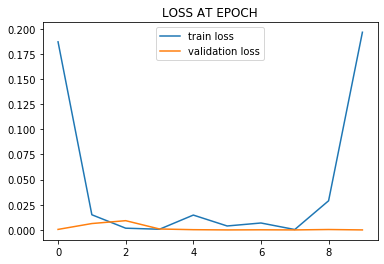

In [27]:
plt.plot(train_losses,label='train loss')
plt.plot(test_losses,label='validation loss')
plt.title('LOSS AT EPOCH')
plt.legend()

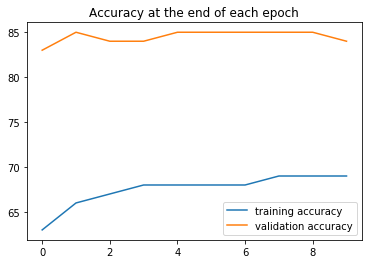

In [28]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [61]:
AlexNetModel = models.alexnet(pretrained=True)

In [62]:
AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [63]:
for param in AlexNetModel.parameters():
    param.requires_grad = False

In [64]:
torch.manual_seed(42)

AlexNetModel.classifier = nn.Sequential(nn.Linear(9216,1024),
                                       nn.ReLU(),
                                       nn.Dropout(0.5),
                                       nn.Linear(1024,15),
                                       nn.LogSoftmax(dim=1))

In [65]:
for param in AlexNetModel.parameters():
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
15360
15


In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetModel.classifier.parameters(),lr=0.001)

In [67]:
import time
start_time = time.time()

epochs = 1

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train,y_train) in enumerate(train_loader):
        
        b += 1
        
        y_pred = AlexNetModel(X_train)
        loss = criterion(y_pred,y_train)
        
        # TaLLy the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200 == 0:
            print(f'Epoch: {i:2} Loss: {loss.item():10.8f} Acc:{trn_corr.item()*100/(10*b):7.3f}%')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    # TEST SET!
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
                
            y_val = AlexNetModel(X_test)
            
            predicted = torch.max(y_val.data, 1)[1]
            batch_corr = (predicted == y_test).sum()
            tst_corr += batch_corr
            
    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

total_time = time.time() - start_time
print(f'Total Time: {total_time/60} minutes')

Epoch:  0 Loss: 0.18327042 Acc: 61.850%
Epoch:  0 Loss: 0.28026021 Acc: 70.550%
Epoch:  0 Loss: 0.07313012 Acc: 74.300%
Epoch:  0 Loss: 1.26820898 Acc: 75.912%
Epoch:  0 Loss: 0.58566386 Acc: 77.080%
Epoch:  0 Loss: 0.18532416 Acc: 78.317%
Epoch:  0 Loss: 0.32517427 Acc: 78.671%
Epoch:  0 Loss: 0.86061829 Acc: 79.362%
Epoch:  0 Loss: 0.17429745 Acc: 80.294%
Epoch:  0 Loss: 2.06677294 Acc: 80.915%
Epoch:  0 Loss: 0.23509113 Acc: 81.391%
Epoch:  0 Loss: 0.57687688 Acc: 81.829%
Epoch:  0 Loss: 1.59817362 Acc: 82.431%
Epoch:  0 Loss: 0.51441085 Acc: 82.764%
Epoch:  0 Loss: 0.09939682 Acc: 83.150%
Epoch:  0 Loss: 0.50867903 Acc: 83.466%
Epoch:  0 Loss: 0.35325736 Acc: 83.765%
Total Time: 30.518432490030925 minutes


In [2]:
d = models.

NameError: name 'models' is not defined